# Transform Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../src')
import utils.utils as utils
import utils.binning as binning

# !pip freeze > ../requirements.txt

In [78]:
raw = pd.read_csv(r'..\data\backup\raw_set.csv').drop(['SK_ID_CURR.1', 'RN', 'SK_ID_CURR.2', 'RN.1'], axis=1)

# Export data types
types = pd.DataFrame(raw.dtypes).reset_index()
types.columns = ['column', 'dtype']
types.to_csv('../log/dtype.csv')

# Export data description
ddesc = raw.describe().T
ddesc.to_csv('../log/ddesc.csv')

# Export object data
dobject = []
for col in raw.columns:
    if raw[col].dtype == 'object' or raw[col].dtype.name == 'category':
        dobject.append([col, raw[col].dtype, raw[col].nunique(), raw[col].unique()])
dobject_df = pd.DataFrame(dobject, columns=['column', 'dtype', 'nunique', 'unique_values'])
dobject_df.to_csv('../log/dobject.csv')

## Transform object data

In [ ]:
def auto_transform_object(df, max_unique=10, output_path = "."):
    object_col = []
    log_binary_bin = []
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            object_col.append(col)
    for col in object_col: 
        nunique = df[col].nunique()
        if nunique == 2: # Transform binary features -> dummy and log recode table
            vals = list(df[col].unique())
            df[col] = np.where(df[col] == vals[0], 1, np.where(df[col] == vals[1], 0, np.nan))
            log_binary_bin.append([col, vals[0], vals[1]])
        elif nunique > 2 and nunique < max_unique: # Transform 'object' to 'category' features to pass through lightgbm
            df[col] = df[col].astype('category')
        elif nunique > max_unique: # Bypass features with too many unique values
            print(f'{col} has more than {max_unique} unique values, bypassed.')
    pd.DataFrame(log_binary_bin, columns=['column', 'bin_1', 'bin_0']).to_csv(output_path, index=False)

auto_transform_object(raw, max_unique=10, output_path = '../log/log_binary_bin.csv')

In [80]:
# raw.CODE_GENDER.unique()
# ['M', 'F', 'XNA']
# Categories (3, object): ['F', 'M', 'XNA']
raw['CODE_GENDER'] = np.where(raw['CODE_GENDER'] == 'M', 1, np.where(raw['CODE_GENDER'] == 'F', 0, np.nan))

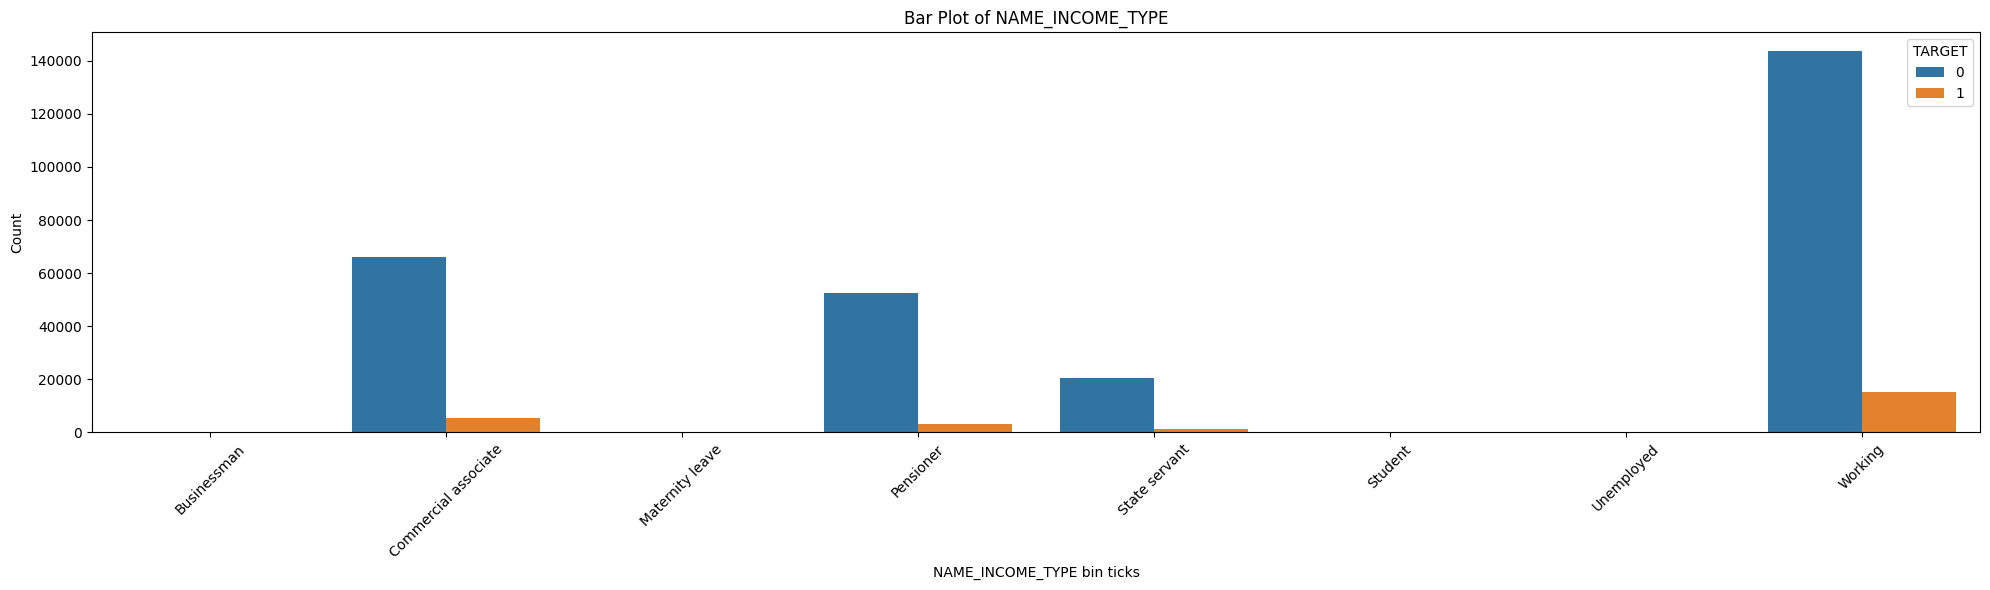

In [81]:
# raw.NAME_INCOME_TYPE.unique()
# ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']
# Categories (8, object): ['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working']
utils._plot_bar_hue(raw, 'NAME_INCOME_TYPE', 'TARGET')

In [82]:
# Group infrequent observes in to 'Others' group
raw['NAME_INCOME_TYPE'] = raw['NAME_INCOME_TYPE'].apply(lambda x: 'Others' if x in ['Unemployed', 'Student', 'Businessman', 'Maternity leave'] else x)
raw['NAME_INCOME_TYPE'] = raw['NAME_INCOME_TYPE'].astype('category')

In [83]:
# raw.NAME_TYPE_SUITE.unique()
# ['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', NaN, 'Other_B', 'Group of people']
# Categories (7, object): ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied']
raw['IS_UNACCOMPANIED'] = np.where(raw['NAME_TYPE_SUITE'] == 'Unaccompanied', 1, np.where(raw['NAME_TYPE_SUITE'].isna(), np.nan, 0))
raw['NAME_TYPE_SUITE'] = raw['NAME_TYPE_SUITE'].astype('category')

In [84]:
# raw.NAME_FAMILY_STATUS.unique()
# ['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']
# Categories (6, object): ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Unknown', 'Widow']
raw['IS_SINGLE'] = np.where(raw['NAME_FAMILY_STATUS'] == 'Single / not married', 1, np.where(raw['NAME_FAMILY_STATUS'] == 'Unknown', np.nan, 0))
raw['NAME_FAMILY_STATUS'] = raw['NAME_FAMILY_STATUS'].astype('category')

In [85]:
# raw.OCCUPATION_TYPE.unique()
# array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
#        'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
#        'Private service staff', 'Medicine staff', 'Security staff',
#        'High skill tech staff', 'Waiters/barmen staff',
#        'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
#        'HR staff'], dtype=object)
raw['OCCUPATION_TYPE'] = raw['OCCUPATION_TYPE'].astype('category')

In [ ]:
# raw.ORGANIZATION_TYPE.unique()
# array(['Business Entity Type 3', 'School', 'Government', 'Religion',
#        'Other', 'XNA', 'Electricity', 'Medicine',
#        'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
#        'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
#        'Industry: type 11', 'Military', 'Services', 'Security Ministries',
#        'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
#        'Trade: type 2', 'University', 'Transport: type 3', 'Police',
#        'Business Entity Type 1', 'Postal', 'Industry: type 4',
#        'Agriculture', 'Restaurant', 'Culture', 'Hotel',
#        'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
#        'Industry: type 9', 'Insurance', 'Trade: type 6',
#        'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
#        'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
#        'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
#        'Industry: type 13', 'Trade: type 4', 'Telecom',
#        'Industry: type 8', 'Realtor', 'Industry: type 6'], dtype=object)
def category(val):
    if 'Industry' in val: return 'industry'
    if 'Trade' in val: return 'trade'
    if 'Transport' in val: return 'transport'
    if 'Business Entity' in val: return 'business'
    if val in ['XNA']: return 'unknown'
    if val in ['Self-employed']: return 'self-employed'
    if val in ['Other']: return 'others_1'
    else : return 'others_2'
    return val
raw['ORGANIZATION_TYPE'] = raw['ORGANIZATION_TYPE'].apply(category)
raw['ORGANIZATION_TYPE'] = raw['ORGANIZATION_TYPE'].astype('category')

## Transform numeric data

In [87]:
# '365243' here means N/A => replace with np.nan
raw['DAYS_EMPLOYED'] = np.where(raw['DAYS_EMPLOYED'] == '365243', np.nan, np.where(raw['DAYS_EMPLOYED'].isna(), np.nan, raw['DAYS_EMPLOYED']))

# Drop observe with AMT_INCOME_TOTAL of max
raw = raw[raw['AMT_INCOME_TOTAL'] != raw['AMT_INCOME_TOTAL'].max()]

## Train-test Split

In [88]:
train_df, test_df = train_test_split(raw, test_size=0.2, stratify=raw['TARGET'], random_state=810)

## Binning OWN_CAR_AGE and AMT_INCOME_TOTAL

<Axes: title={'center': 'Histogram of OWN_CAR_AGE with 91 bins'}, xlabel='OWN_CAR_AGE bin ticks', ylabel='Count'>

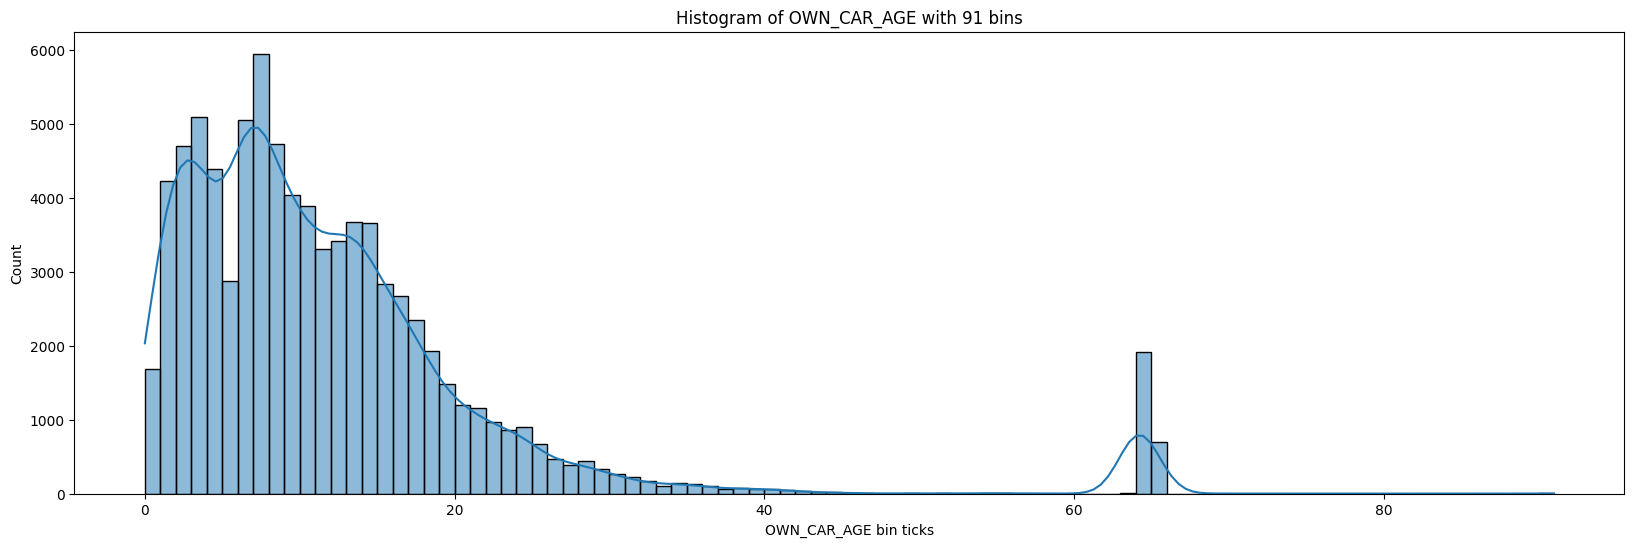

In [89]:
utils._plot_histogram(train_df, 'OWN_CAR_AGE', 91)

In [90]:
df_summary, IV, thres = binning._bin_table(train_df, train_df['TARGET'], feature='OWN_CAR_AGE', qcut=[-np.inf, 6, 9, 13, 18, np.inf])
print(df_summary)

Information Value of OWN_CAR_AGE column: 0.043784546969575636
              Thres  #GOOD  #BAD  No_Obs       COLUMN   GOOD/BAD      %BAD  \
bins                                                                         
(-inf, 6.0]     6.0  26436  1598   28034  OWN_CAR_AGE  16.543179  0.263436   
(6.0, 9.0]      9.0  13778   948   14726  OWN_CAR_AGE  14.533755  0.156281   
(9.0, 13.0]    13.0  13151  1142   14293  OWN_CAR_AGE  11.515762  0.188262   
(13.0, 18.0]   18.0  12262  1180   13442  OWN_CAR_AGE  10.391525  0.194527   
(18.0, inf]     inf  11837  1198   13035  OWN_CAR_AGE   9.880634  0.197494   

                 %GOOD       WOE        IV  
bins                                        
(-inf, 6.0]   0.341268  0.258860  0.020148  
(6.0, 9.0]    0.177863  0.129360  0.002792  
(9.0, 13.0]   0.169769 -0.103397  0.001912  
(13.0, 18.0]  0.158293 -0.206123  0.007469  
(18.0, inf]   0.152806 -0.256537  0.011464  


d:\huynq1\202507-homecredit-pd\notebook\../src\utils\binning.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_table = bin_data.groupby('bins')['target'].value_counts().unstack(fill_value=0) # Nếu 1 bin không có target class nào thì count = 0 luôn


In [91]:
# Recode own car age into 5 bins follow thres
train_df['OWN_CAR_AGE'] = pd.cut(train_df['OWN_CAR_AGE'], bins=thres)
train_df['OWN_CAR_AGE'] = np.where(train_df['OWN_CAR_AGE'].isna() == True, 'NA', train_df['OWN_CAR_AGE'])
train_df['OWN_CAR_AGE'] = train_df['OWN_CAR_AGE'].astype(object)

Information Value of OWN_CAR_AGE column: 0.020472045272503556
               #GOOD   #BAD  No_Obs       COLUMN   GOOD/BAD      %BAD  \
bins                                                                    
(-inf, 6.0]    26436   1598   28034  OWN_CAR_AGE  16.543179  0.080467   
(6.0, 9.0]     13778    948   14726  OWN_CAR_AGE  14.533755  0.047737   
(9.0, 13.0]    13151   1142   14293  OWN_CAR_AGE  11.515762  0.057505   
(13.0, 18.0]   12262   1180   13442  OWN_CAR_AGE  10.391525  0.059419   
(18.0, inf]    11837   1198   13035  OWN_CAR_AGE   9.880634  0.060325   
NA            148685  13793  162478  OWN_CAR_AGE  10.779743  0.694547   

                 %GOOD       WOE        IV  
bins                                        
(-inf, 6.0]   0.116896  0.373437  0.013604  
(6.0, 9.0]    0.060924  0.243937  0.003217  
(9.0, 13.0]   0.058152  0.011180  0.000007  
(13.0, 18.0]  0.054221 -0.091546  0.000476  
(18.0, inf]   0.052342 -0.141960  0.001133  
NA            0.657465 -0.054868  0.00

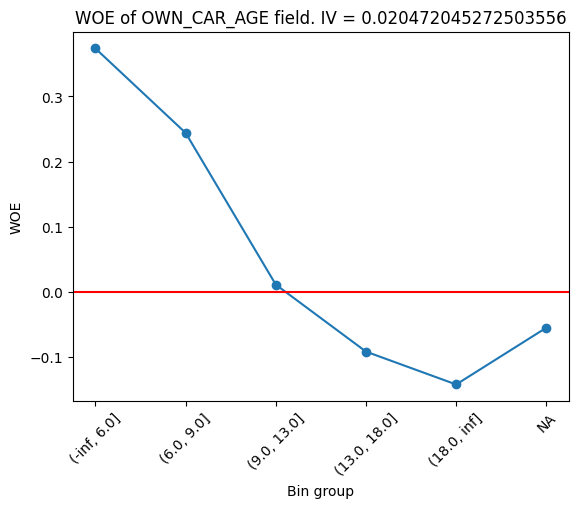

In [92]:
df_summary, IV, thres = binning._bin_table(train_df, train_df['TARGET'], feature='OWN_CAR_AGE')
print(df_summary)
binning._woe_plot(df_summary, IV)

In [93]:
train_df['OWN_CAR_AGE'] = train_df['OWN_CAR_AGE'].astype('category')

In [ ]:
# df_summary, IV, thres = binning._bin_table(test_df, test_df['TARGET'], feature='OWN_CAR_AGE', qcut=)
test_df['OWN_CAR_AGE'] = pd.cut(test_df['OWN_CAR_AGE'], bins=[-np.inf, 6, 9, 13, 18, np.inf])
test_df['OWN_CAR_AGE'] = np.where(test_df['OWN_CAR_AGE'].isna() == True, 'NA', test_df['OWN_CAR_AGE'])
test_df['OWN_CAR_AGE'] = test_df['OWN_CAR_AGE'].astype('category')

In [95]:
train_df.to_csv('../data/cleaned_train_data.csv', index=False)
test_df.to_csv('../data/cleaned_test_data.csv', index=False)

# Transform Submit Dataset

In [11]:
submit_set = pd.read_csv('../data/backup/submit_set.csv').drop(['SK_ID_CURR.1', 'RN', 'SK_ID_CURR.2', 'RN.1'], axis=1)

In [12]:
auto_transform_object(submit_set, max_unique=10, output_path = '../log/submit_set_log_binary_bin.csv')

submit_set['CODE_GENDER'] = np.where(submit_set['CODE_GENDER'] == 'M', 1, np.where(submit_set['CODE_GENDER'] == 'F', 0, np.nan))

submit_set['NAME_INCOME_TYPE'] = submit_set['NAME_INCOME_TYPE'].apply(lambda x: 'Others' if x in ['Unemployed', 'Student', 'Businessman', 'Maternity leave'] else x)
submit_set['NAME_INCOME_TYPE'] = submit_set['NAME_INCOME_TYPE'].astype('category')

submit_set['IS_UNACCOMPANIED'] = np.where(submit_set['NAME_TYPE_SUITE'] == 'Unaccompanied', 1, np.where(submit_set['NAME_TYPE_SUITE'].isna(), np.nan, 0))
submit_set['NAME_TYPE_SUITE'] = submit_set['NAME_TYPE_SUITE'].astype('category')

submit_set['IS_SINGLE'] = np.where(submit_set['NAME_FAMILY_STATUS'] == 'Single / not married', 1, np.where(submit_set['NAME_FAMILY_STATUS'] == 'Unknown', np.nan, 0))
submit_set['NAME_FAMILY_STATUS'] = submit_set['NAME_FAMILY_STATUS'].astype('category')

submit_set['OCCUPATION_TYPE'] = submit_set['OCCUPATION_TYPE'].astype('category')

submit_set['ORGANIZATION_TYPE'] = submit_set['ORGANIZATION_TYPE'].apply(category)
submit_set['ORGANIZATION_TYPE'] = submit_set['ORGANIZATION_TYPE'].astype('category')

submit_set['DAYS_EMPLOYED'] = np.where(submit_set['DAYS_EMPLOYED'] == '365243', np.nan, np.where(submit_set['DAYS_EMPLOYED'].isna(), np.nan, submit_set['DAYS_EMPLOYED']))

submit_set['OWN_CAR_AGE'] = pd.cut(submit_set['OWN_CAR_AGE'], bins=[-np.inf, 6, 9, 13, 18, np.inf])
submit_set['OWN_CAR_AGE'] = np.where(submit_set['OWN_CAR_AGE'].isna() == True, 'NA', submit_set['OWN_CAR_AGE'])
submit_set['OWN_CAR_AGE'] = submit_set['OWN_CAR_AGE'].astype('category')

OCCUPATION_TYPE has more than 10 unique values, bypassed.
ORGANIZATION_TYPE has more than 10 unique values, bypassed.


In [13]:
submit_type = pd.DataFrame(submit_set.dtypes).reset_index()
submit_type.columns = ['column', 'dtype']
submit_type.to_csv('../log/submit_type.csv')

# Export data description
submit_ddesc = submit_set.describe().T
submit_ddesc.to_csv('../log/submit_ddesc.csv')

# Export object data
submit_dobject = []
for col in submit_set.columns:
    if submit_set[col].dtype == 'object' or submit_set[col].dtype.name == 'category':
        submit_dobject.append([col, submit_set[col].dtype, submit_set[col].nunique(), submit_set[col].unique()])
submit_dobject_df = pd.DataFrame(submit_dobject, columns=['column', 'dtype', 'nunique', 'unique_values'])
submit_dobject_df.to_csv('../log/submit_dobject.csv')

In [14]:
submit_set.to_csv('../data/cleaned_submit_data.csv', index=False)